**Target**:
> Model needs to be slightly changed for the following reasons: 
1.   Reduce the number of parameters to less than 10000. Compensate this by adding a convolution layer with padding and tune the learning rate and reduce batch size
2. Hit an accuracy of 99.4% consistently.  



**Results**:

> 1.   Parameters: 8790
2.   Best Training Accuracy: 98.038%
3.   Best Test Accuracy: 99.48%





**Analysis**:

> 1.   Model is underfitting.
2.   Learning rate can further be tuned to increase accuracy.















In [2]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np

In [3]:
torch.manual_seed(1)

In [4]:
train_set = torchvision.datasets.MNIST(root='/Data',
                                       train = True,
                                       download = True,
                                       transform=transforms.Compose([
                                                                     transforms.ToTensor(),
                                                                     
                                       ]),
                                       )
test_set = torchvision.datasets.MNIST(root='/Data',
                                       train = False,
                                       download = True,
                                       transform=transforms.Compose([
                                                                     transforms.ToTensor(),
                                                                     
                                       ]),
                                       )

Extracting /Data/MNIST/raw/train-images-idx3-ubyte.gz to /Data/MNIST/raw


Extracting /Data/MNIST/raw/train-labels-idx1-ubyte.gz to /Data/MNIST/raw




Extracting /Data/MNIST/raw/t10k-images-idx3-ubyte.gz to /Data/MNIST/raw


Extracting /Data/MNIST/raw/t10k-labels-idx1-ubyte.gz to /Data/MNIST/raw
Processing...
Done!


/opt/conda/lib/python3.7/site-packages/torchvision/datasets/mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /opt/conda/conda-bld/pytorch_1603729138878/work/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [52]:
print(f"""Shape: {train_set.data.shape}
Minimum: {torch.min(train_set.transform(train_set.data.numpy()))}
Maximum: {torch.max(train_set.transform(train_set.data.numpy()))}
Mean: {torch.mean(train_set.transform(train_set.data.numpy()))}
Standard Deviation: {torch.std(train_set.transform(train_set.data.numpy()))}
Variance : {torch.var(train_set.transform(train_set.data.numpy()))}""")


Shape: torch.Size([60000, 28, 28])
Minimum: 0.0
Maximum: 1.0
Mean: 0.13066047430038452
Standard Deviation: 0.30810782313346863
Variance : 0.09493042528629303


In [5]:
train_set.transform = transforms.Compose([
                                        transforms.RandomRotation((-7.0, 7.0), fill=(1,)),
                                        transforms.ToTensor(),
                                        transforms.Normalize((0.13066047430038452,),(0.30810782313346863,))
                                        ])
test_set.transform =  transforms.Compose([
                                        transforms.ToTensor(),
                                        transforms.Normalize((0.13066047430038452,),(0.30810782313346863,))
                                        ])


In [54]:
train_set.transform , test_set.transform

(Compose(
     RandomRotation(degrees=[-7.0, 7.0], resample=False, expand=False, fill=(1,))
     ToTensor()
     Normalize(mean=(0.13066047430038452,), std=(0.30810782313346863,))
 ),
 Compose(
     ToTensor()
     Normalize(mean=(0.13066047430038452,), std=(0.30810782313346863,))
 ))

In [55]:
images, labels = next(iter(train_loader))

In [56]:
grid = torchvision.utils.make_grid(images, nrow=20)

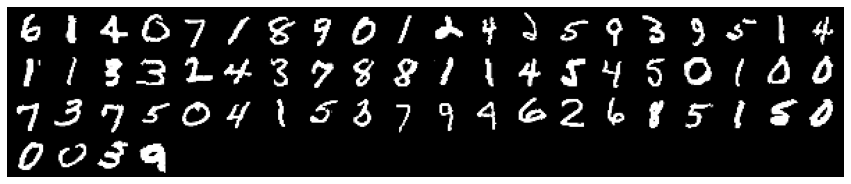

In [57]:
plt.figure(figsize = (15,15))
plt.imshow(np.transpose(grid, (1,2,0)), cmap = 'gray')
plt.axis('off')
plt.show()

In [6]:
class BatchNorm(nn.BatchNorm2d):
    def __init__(self, num_features, eps=1e-05, momentum=0.1, weight=True, bias=True):
        super().__init__(num_features, eps=eps, momentum=momentum)
        self.weight.data.fill_(1.0)
        self.bias.data.fill_(0.0)
        self.weight.requires_grad = weight
        self.bias.requires_grad = bias


class GhostBatchNorm(BatchNorm):
    def __init__(self, num_features, num_splits, **kw):
        super().__init__(num_features, **kw)
        self.num_splits = num_splits
        self.register_buffer('running_mean', torch.zeros(num_features * self.num_splits))
        self.register_buffer('running_var', torch.ones(num_features * self.num_splits))

    def train(self, mode=True):
        if (self.training is True) and (mode is False):  # lazily collate stats when we are going to use them
            self.running_mean = torch.mean(self.running_mean.view(self.num_splits, self.num_features), dim=0).repeat(
                self.num_splits)
            self.running_var = torch.mean(self.running_var.view(self.num_splits, self.num_features), dim=0).repeat(
                self.num_splits)
        return super().train(mode)

    def forward(self, input):
        N, C, H, W = input.shape
        if self.training or not self.track_running_stats:
            return F.batch_norm(
                input.view(-1, C * self.num_splits, H, W), self.running_mean, self.running_var,
                self.weight.repeat(self.num_splits), self.bias.repeat(self.num_splits),
                True, self.momentum, self.eps).view(N, C, H, W)
        else:
            return F.batch_norm(
                input, self.running_mean[:self.num_features], self.running_var[:self.num_features],
                self.weight, self.bias, False, self.momentum, self.eps)

In [7]:
class CustomModel(nn.Module):
  
   
  def Conv_Blocks(self, Bias, relu, batch_norm, Dropout, GBN, in_channels, out_channels, kernel_size = 3, stride = 1, padding = 0):
    self.conv_struct = [nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding, bias = Bias)]
    if relu:
      self.conv_struct.append(nn.ReLU())
    if batch_norm:
      self.conv_struct.append(nn.BatchNorm2d(out_channels))
    elif GBN:
      self.conv_struct.append(GhostBatchNorm(out_channels, 4))
    if Dropout:
      self.conv_struct.append(nn.Dropout(int(Dropout)))
    return nn.Sequential(*self.conv_struct)

  def __init__(self, Bias, relu = True, batch_norm = True, Dropout = False, GBN = False):
    super().__init__()
    self.conv_Block1 = self.Conv_Blocks(Bias, relu, batch_norm, Dropout, GBN, in_channels = 1, out_channels = 10, kernel_size = 3, padding=1) # Output size = 28
    self.conv_Block2 = self.Conv_Blocks(Bias, relu, batch_norm, Dropout, GBN, in_channels = 10, out_channels = 10, kernel_size = 3) # Output size = 26
    self.conv_Block3 = self.Conv_Blocks(Bias, relu, batch_norm, Dropout, GBN, in_channels = 10, out_channels = 10, kernel_size = 3) # Output size = 24
    self.conv_Block4 = self.Conv_Blocks(Bias, relu, batch_norm, Dropout, GBN, in_channels = 10, out_channels = 10, kernel_size = 3) # Output size = 22
    self.conv_Block5 = self.Conv_Blocks(Bias, relu, batch_norm, Dropout, GBN, in_channels = 10, out_channels = 20, kernel_size = 3) # Output size = 20

    self.transition_block1 = nn.Sequential(
        nn.MaxPool2d(kernel_size = 2, stride = 2),
        nn.Conv2d(in_channels = 20, out_channels = 10, kernel_size = 1, bias = False)
    ) # Output size = 10      

    self.conv_Block6 = self.Conv_Blocks(Bias, relu, batch_norm, Dropout, GBN, in_channels = 10, out_channels = 10, kernel_size = 3) # Output size = 8
    self.conv_Block7 = self.Conv_Blocks(Bias, relu, batch_norm, Dropout, GBN, in_channels = 10, out_channels = 10, kernel_size = 3) # Output size = 6
    self.conv_Block8 = self.Conv_Blocks(Bias, relu, batch_norm, Dropout, GBN, in_channels = 10, out_channels = 20, kernel_size = 3) # Output size = 4
    
    self.gap = nn.AvgPool2d(kernel_size = 4) # Output size = 1

    self.merge_block1 = nn.Sequential(        
        nn.Conv2d(in_channels = 20, out_channels = 10, kernel_size = 1, bias = False)
    ) # Output size = 1

    

  def forward(self, image):
    image = self.conv_Block5(self.conv_Block4(self.conv_Block3(self.conv_Block2(self.conv_Block1(image)))))   
    image = self.transition_block1(image)
    image = self.conv_Block8(self.conv_Block7(self.conv_Block6(image)))
    image = self.gap(image)
    image = self.merge_block1(image)
    
    image = image.reshape(-1,10)
    return F.log_softmax(image, dim=-1)




In [60]:
print(next(iter(model.parameters())),next(iter(model.parameters())).shape)

Parameter containing:
tensor([[[[-1.0858e-03, -8.6226e-03, -4.3772e-03],
          [-1.0945e-02,  6.6939e-03,  4.3318e-04],
          [ 2.7708e-02, -7.5353e-03, -2.4912e-05]]],


        [[[ 6.8644e-03, -3.6404e-03, -1.8852e-02],
          [ 1.8784e-03,  1.8299e-02,  3.3750e-02],
          [ 2.0352e-02,  2.9708e-02, -9.5934e-03]]],


        [[[ 3.4578e-03,  1.6871e-02,  1.1030e-02],
          [-1.3722e-02, -2.7467e-02,  6.5440e-03],
          [-3.2086e-02, -3.8822e-02,  2.7614e-03]]],


        [[[ 4.0713e-02,  2.1883e-02, -1.7149e-02],
          [ 1.5133e-02, -9.0755e-03,  5.2738e-03],
          [-8.8267e-03, -8.8859e-03,  5.7455e-03]]],


        [[[-6.6574e-03, -8.4036e-04,  6.4813e-03],
          [ 2.1987e-03, -6.0003e-03,  1.0876e-02],
          [-3.1942e-03,  1.1377e-02,  3.5710e-03]]],


        [[[-4.7688e-03,  2.6394e-02, -6.3784e-03],
          [-2.8510e-04, -5.4290e-04, -1.3148e-02],
          [ 1.4089e-02, -1.5438e-02,  7.7978e-03]]],


        [[[-4.7839e-03,  4.9475e-03,

# Training the entire set

In [9]:
class regularizer:
  def __init__(self, model, LR, Momentum, l1_lambda = 0, l2_lambda = 0):
    self.loss, self.loss_value = 0,0
    self.optimizer = optim.SGD(model.parameters(), lr = LR, momentum = Momentum)
    self.l1_lambda, self.l2_lambda = l1_lambda, l2_lambda
    if self.l2_lambda > 0:
        self.optimizer = optim.SGD(model.parameters(), lr = LR, momentum = Momentum, weight_decay = l2_lambda)

  def Regularizer(self, preds, targets, mode=None, model=None):
    self.loss = F.nll_loss(preds, targets)
    self.loss_value += self.loss.item()
    if mode == 'train':      
      self.optimizer.zero_grad()      
      if self.l1_lambda > 0:
        self.loss_value -= self.loss.item()
        l1 = 0
        for params in model.parameters():
          l1 += params.abs().sum()
        self.loss += l1*self.l1_lambda
        self.loss_value += self.loss.item()      
      self.loss.backward()
      self.optimizer.step()
    

    


In [13]:
def train_model(model, device, train_loader, regularizer):
  train_accuracy, total_train_correct, total_train_processed = 0, 0, 0    
  model.train()
  regularizer.loss_value = 0
  for batch in train_loader: 
    images, labels = batch
    images, labels = images.to(device), labels.to(device)
    pred = model(images)
    pred_values = pred.argmax(dim=1, keepdim=True)
    regularizer.Regularizer(pred, labels, 'train', model)         
    
    total_train_correct += pred_values.eq(labels.view_as(pred_values)).sum().item()
    total_train_processed += len(images)
    
  train_accuracy = 100*(total_train_correct/total_train_processed)
  regularizer.loss_value /= len(train_loader.dataset) 
  return regularizer.loss_value, train_accuracy  



def test_model(model, device, test_loader, loss_function):
  test_accuracy, total_test_correct, total_test_processed = 0, 0, 0    
  model.eval()
  loss_function.loss_value = 0
  for batch in test_loader: 
    images, labels = batch
    images, labels = images.to(device), labels.to(device)     
    pred = model(images)
    pred_values = pred.argmax(dim=1, keepdim=True)
    loss_function.Regularizer(pred, labels)          
    
    total_test_correct += pred_values.eq(labels.view_as(pred_values)).sum().item()
    total_test_processed += len(images)
    
  test_accuracy = 100*(total_test_correct/total_test_processed)
  loss_function.loss_value /= len(test_loader.dataset) 
  return loss_function.loss_value, test_accuracy
  





In [14]:
def train_epochs(epochs, model, device, train_loader, Regularizer, test_loader):
  train_losses, train_accuracies, test_losses, test_accuracies = [], [], [], []
  for epoch in range(epochs):
    print(f"Epoch {epoch+1} in progress....")
    train_loss, train_accuracy = train_model(model, device, train_loader, Regularize)      
    test_loss, test_accuracy = test_model(model, device, test_loader, Regularize)
    print(f"\nEpoch : {epoch+1} \n\nAverage Train Loss : {train_loss :.9f} \nTrain Accuracy : {train_accuracy : .4f}% \n\nAverage Test Loss : {test_loss :.9f} \nTest Accuracy : {test_accuracy : .4f}% \n\n")
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
    test_losses.append(test_loss)
    test_accuracies.append(test_accuracy)
  return train_losses, train_accuracies, test_losses, test_accuracies
  

In [64]:
Runs={'BatchNorm':[True,True,True,False,False],'Lambda1':[0.0001,0,0.0001,0,0.0001],'Lambda2':[0,0.0001,0.0001,0,0.0001],'GBN':[False,False,False,True,True],'batch_size':[64,64,64,32,32]}
Stages=['BatchNorm with L1', 'BatchNorm with L2', 'BatchNorm with L1 and L2', 'GhostBatchNorm', 'GhostBatchNorm with L1 and L2']

In [65]:
validation_accuracies, validation_losses=[],[]
use_cuda = torch.cuda.is_available() # check if GPU available
device = torch.device("cuda" if use_cuda else "cpu") # use cpu if gpu is not available 
for run in range(5):
    train_loader = torch.utils.data.DataLoader(dataset = train_set,
                                           batch_size = Runs['batch_size'][run],
                                           shuffle = True,
                                           pin_memory = True)
    test_loader = torch.utils.data.DataLoader(dataset = test_set, 
                                          batch_size = Runs['batch_size'][run],
                                          shuffle = True,
                                          pin_memory = True)
    model = CustomModel(Bias=False, relu = True, batch_norm = Runs['BatchNorm'][run], Dropout = 0.1, GBN = Runs['GBN'][run]).to(device)
    Regularize = regularizer(model, 0.01, 0.9, l1_lambda = Runs['Lambda1'][run], l2_lambda = Runs['Lambda2'][run])
    print(f'{Stages[run]} : \n')
    train_losses, train_accuracies, test_losses, test_accuracies = train_epochs(25, model, device, train_loader, Regularize, test_loader)
    validation_accuracies.append(test_accuracies)
    validation_losses.append(test_losses)

BatchNorm with L1 : 

Epoch 1 in progress....

Epoch : 1 

Average Train Loss : 0.004649156 
Train Accuracy :  94.2467% 

Average Test Loss : 0.000810067 
Test Accuracy :  98.5100% 


Epoch 2 in progress....

Epoch : 2 

Average Train Loss : 0.002082151 
Train Accuracy :  98.0000% 

Average Test Loss : 0.000667221 
Test Accuracy :  98.8200% 


Epoch 3 in progress....

Epoch : 3 

Average Train Loss : 0.001889467 
Train Accuracy :  98.3133% 

Average Test Loss : 0.000621789 
Test Accuracy :  98.8300% 


Epoch 4 in progress....

Epoch : 4 

Average Train Loss : 0.001781753 
Train Accuracy :  98.5150% 

Average Test Loss : 0.000492456 
Test Accuracy :  99.0200% 


Epoch 5 in progress....

Epoch : 5 

Average Train Loss : 0.001714684 
Train Accuracy :  98.5967% 

Average Test Loss : 0.000471382 
Test Accuracy :  99.0300% 


Epoch 6 in progress....

Epoch : 6 

Average Train Loss : 0.001636926 
Train Accuracy :  98.7733% 

Average Test Loss : 0.000555704 
Test Accuracy :  98.9100% 


Epoch 


Epoch : 1 

Average Train Loss : 0.004921401 
Train Accuracy :  93.4000% 

Average Test Loss : 0.000764758 
Test Accuracy :  98.6000% 


Epoch 2 in progress....

Epoch : 2 

Average Train Loss : 0.002109005 
Train Accuracy :  97.9833% 

Average Test Loss : 0.000645501 
Test Accuracy :  98.7000% 


Epoch 3 in progress....

Epoch : 3 

Average Train Loss : 0.001891157 
Train Accuracy :  98.3900% 

Average Test Loss : 0.000682281 
Test Accuracy :  98.7200% 


Epoch 4 in progress....

Epoch : 4 

Average Train Loss : 0.001787851 
Train Accuracy :  98.4467% 

Average Test Loss : 0.000550486 
Test Accuracy :  98.8100% 


Epoch 5 in progress....

Epoch : 5 

Average Train Loss : 0.001734845 
Train Accuracy :  98.5333% 

Average Test Loss : 0.000530536 
Test Accuracy :  98.9400% 


Epoch 6 in progress....

Epoch : 6 

Average Train Loss : 0.001700817 
Train Accuracy :  98.5183% 

Average Test Loss : 0.000461006 
Test Accuracy :  98.9800% 


Epoch 7 in progress....

Epoch : 7 

Average Train L


Epoch : 1 

Average Train Loss : 0.010557368 
Train Accuracy :  92.5900% 

Average Test Loss : 0.001599071 
Test Accuracy :  98.3100% 


Epoch 2 in progress....

Epoch : 2 

Average Train Loss : 0.005887441 
Train Accuracy :  96.8000% 

Average Test Loss : 0.001346067 
Test Accuracy :  98.6300% 


Epoch 3 in progress....

Epoch : 3 

Average Train Loss : 0.005430181 
Train Accuracy :  97.2100% 

Average Test Loss : 0.001195639 
Test Accuracy :  98.8100% 


Epoch 4 in progress....

Epoch : 4 

Average Train Loss : 0.005140148 
Train Accuracy :  97.4267% 

Average Test Loss : 0.001027198 
Test Accuracy :  99.0000% 


Epoch 5 in progress....

Epoch : 5 

Average Train Loss : 0.005089946 
Train Accuracy :  97.6083% 

Average Test Loss : 0.001118952 
Test Accuracy :  98.8900% 


Epoch 6 in progress....

Epoch : 6 

Average Train Loss : 0.004764935 
Train Accuracy :  97.7200% 

Average Test Loss : 0.000929794 
Test Accuracy :  98.9600% 


Epoch 7 in progress....

Epoch : 7 

Average Train L

Text(0.5, 1.0, 'Test Accuracy')

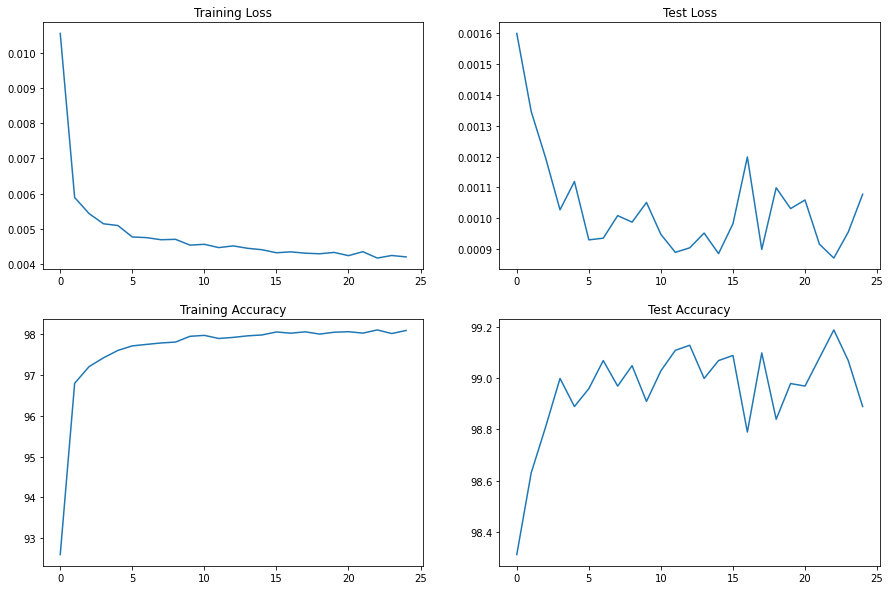

In [66]:
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_accuracies)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_accuracies)
axs[1, 1].set_title("Test Accuracy")

In [70]:
len(validation_accuracies[0]), len(validation_losses[0])

(25, 25)

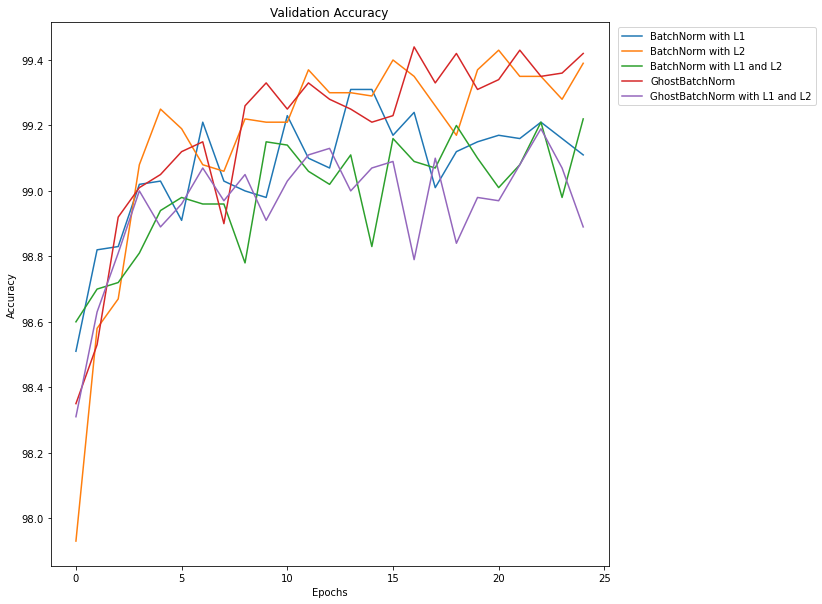

In [90]:

plt.figure(figsize=(10,10))
for index, accuracy in enumerate(validation_accuracies):
    plt.plot(accuracy,label=Stages[index])

plt.legend(loc='upper right',bbox_to_anchor=(1.38,1))
plt.title('Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.savefig('val_acc.png', bbox_inches='tight')
plt.show()


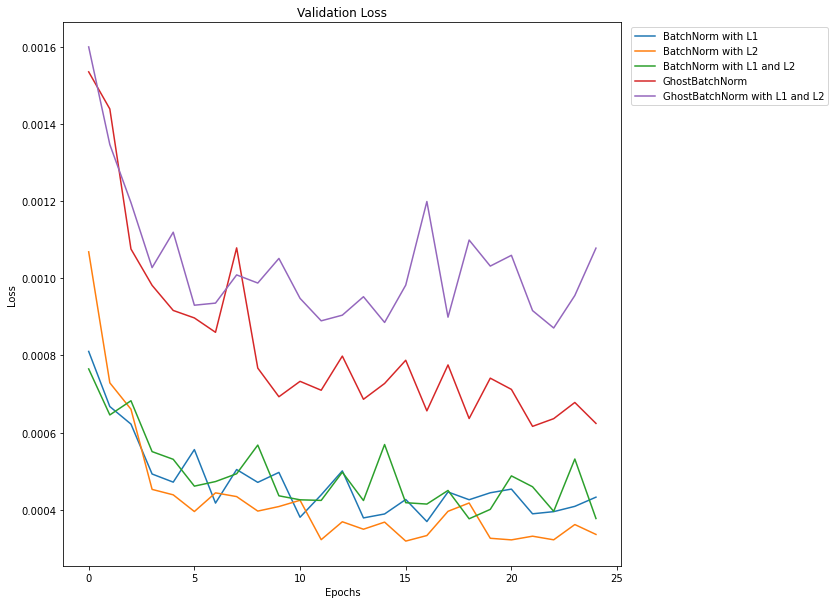

In [91]:
plt.figure(figsize=(10,10))
for index, loss in enumerate(validation_losses):
    plt.plot(loss,label=Stages[index])

plt.legend(loc='upper right',bbox_to_anchor=(1.38,1))
plt.title('Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.savefig('val_loss.png', bbox_inches='tight')
plt.show()

# Plotting Misclassified Images

In [8]:
train_loader = torch.utils.data.DataLoader(dataset = train_set,
                                           batch_size = 64,
                                           shuffle = True,
                                           pin_memory = True)
test_loader = torch.utils.data.DataLoader(dataset = test_set, 
                                          batch_size = 64,
                                          shuffle = True,
                                          pin_memory = True)

In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CustomModel(Bias=False, relu = True, batch_norm = False, Dropout = 0.1, GBN = True).to(device)

In [11]:
optimiser = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

In [14]:
def train_model(model, device, train_loader, optimiser):
  train_loss, train_accuracy, total_train_correct, total_train_processed = 0, 0, 0, 0    
  model.train()
  for batch in train_loader: 
    images, labels = batch
    images, labels = images.to(device), labels.to(device) 
    optimiser.zero_grad()

    pred = model(images)
    pred_values = pred.argmax(dim=1, keepdim=True)
    loss = F.nll_loss(pred, labels)
    

    loss.backward()
    optimiser.step()     
    
     



def test_model(model, device, test_loader, misclassified_imgs, epoch):
  test_loss, test_accuracy, total_test_correct, total_test_processed = 0, 0, 0, 0    
  model.eval()
  for batch in test_loader: 
    images, labels = batch
    images, labels = images.to(device), labels.to(device) 
    
    pred = model(images)
    pred_values = pred.argmax(dim=1, keepdim=True)
    is_correct = pred_values.eq(labels.view_as(pred_values))
    if epoch == 14:
        misclassified_inds = (is_correct==0).nonzero()[:,0]
        for mis_ind in misclassified_inds:
            if len(misclassified_imgs) == 25:
                  break
            misclassified_imgs.append({
                    "target": labels[mis_ind].cpu().numpy(),
                    "pred": pred_values[mis_ind][0].cpu().numpy(),
                    "img": images[mis_ind].cpu().numpy()[0]
                })
    
  

In [15]:
def train_epochs(epochs, model, device, train_loader, optimiser, test_loader):
      misclassified_imgs=[]
      for epoch in range(epochs):
        print(f"Epoch {epoch+1} in progress....")
        train_model(model, device, train_loader, optimiser)      
        test_model(model, device, test_loader, misclassified_imgs, epoch)
        
      return misclassified_imgs

In [16]:
misclassified_images = train_epochs(15, model, device, train_loader, optimiser, test_loader)

Epoch 1 in progress....
Epoch 2 in progress....
Epoch 3 in progress....
Epoch 4 in progress....
Epoch 5 in progress....
Epoch 6 in progress....
Epoch 7 in progress....
Epoch 8 in progress....
Epoch 9 in progress....
Epoch 10 in progress....
Epoch 11 in progress....
Epoch 12 in progress....
Epoch 13 in progress....
Epoch 14 in progress....
Epoch 15 in progress....


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:32: UserWarning: This overload of nonzero is deprecated:
	nonzero()
Consider using one of the following signatures instead:
	nonzero(*, bool as_tuple) (Triggered internally at  /opt/conda/conda-bld/pytorch_1603729138878/work/torch/csrc/utils/python_arg_parser.cpp:882.)


In [17]:
def plot_misclassified_images(img_data, img_name):
  figure = plt.figure(figsize=(10, 10))
  num_of_images = len(img_data)
  for index in range(1, num_of_images + 1):
      plt.subplot(5, 5, index)
      plt.axis('off')
      plt.imshow(img_data[index-1]["img"], cmap='gray_r')
      plt.title("Predicted: %s\nActual: %s" % (img_data[index-1]["pred"], img_data[index-1]["target"]))
  plt.tight_layout()
  plt.savefig(img_name)

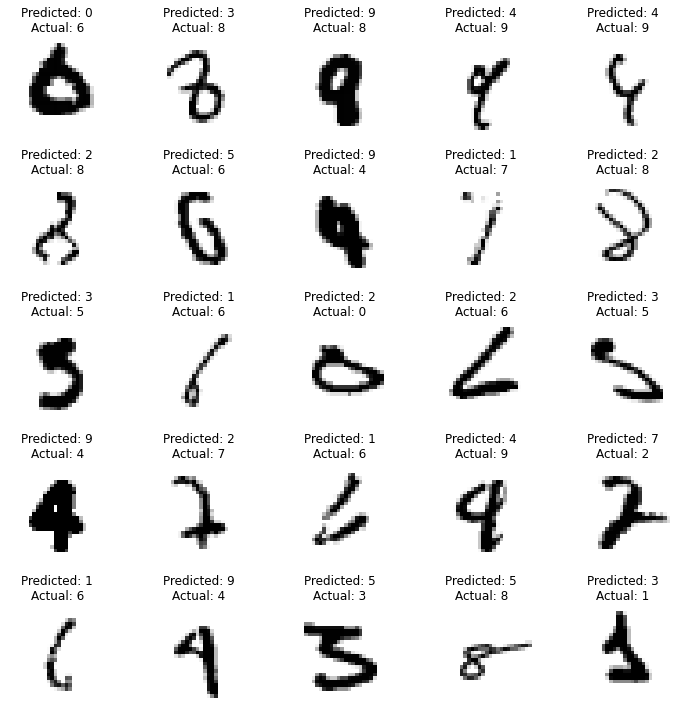

In [18]:
plot_misclassified_images(misclassified_images, "misclassified_images.png")